# Introducción

Este notebook cubre los conceptos básicos de cómo usar Stable Diffusion para crear y modificar imágenes usando pipelines existentes. También veremos brevemente los componentes clave dentro del pipeline, dejando una exploración más profunda para el notebook avanzado. Específicamente, cubriremos:
- Generar imágenes a partir de texto usando `StableDiffusionPipeline` y experimentar con los argumentos disponibles
- Ver algunos de los componentes clave del pipeline en acción
    - El VAE que hace de este un 'modelo de difusión latente'
    - El tokenizador y codificador de texto que procesan el prompt
    - El propio UNet
    - El scheduler, y exploraremos diferentes schedulers
- Replicar el ciclo de muestreo con los componentes del pipeline
- Editar imágenes existentes con el pipeline Img2Img
- Usar los pipelines de inpainting y Depth2Img

❓Si tienes preguntas, publícalas en el canal de Teams y colaborad!


# Configuración

In [4]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
    )

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

img_height = 512
img_width = 512

init_image = download_image(img_url).resize((img_height, img_width))
mask_image = download_image(mask_url).resize((img_height, img_width))

In [5]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generación de Imágenes a partir de Texto

Carguemos un pipeline de Stable Diffusion y veamos lo que puede hacer. Existen varias versiones diferentes de Stable Diffusion, siendo la más reciente al momento de escribir esto la versión 2.1. Si quieres explorar una versión anterior, simplemente reemplaza el ID del modelo por el apropiado (por ejemplo, puedes probar "CompVis/stable-diffusion-v1-4" o elegir un modelo de la [biblioteca de conceptos dreambooth](https://huggingface.co/sd-dreambooth-library)).

In [1]:
# Ejecuta esto y pega tu token de Hugging Face
from huggingface_hub import login
login()

In [6]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

c:\Users\usuario\Documents\Gen-AI-PGTD\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\usuario\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Si te quedas sin memoria de GPU, hay algunas cosas que puedes hacer para reducir el uso de RAM:
- Cargar la versión FP16 (no soportada en todos los sistemas). Con esto, puede que también necesites convertir tensores a torch.float16 al experimentar con componentes individuales del pipeline:

  `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`

- Habilitar attention slicing. Esto reduce el uso de memoria de GPU a costa de una pequeña reducción en la velocidad:

 `pipe.enable_attention_slicing()`
- Reducir el tamaño de las imágenes que generas

Una vez cargado el pipeline, podemos generar una imagen basada en un prompt con el siguiente código:

  0%|          | 0/35 [00:00<?, ?it/s]

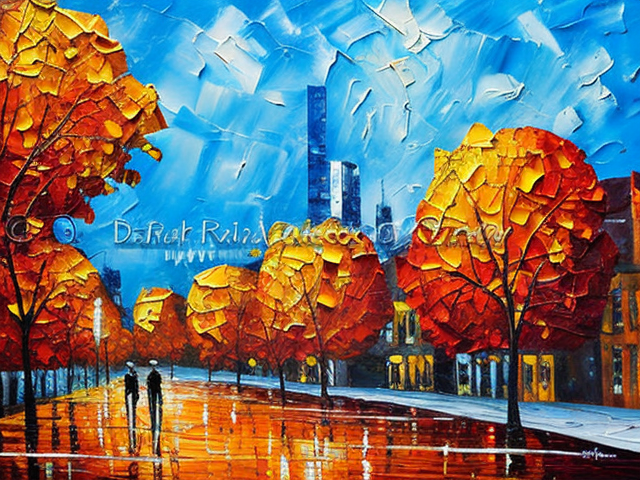

In [ ]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

**Ejercicio:** Dedica un tiempo a experimentar con la celda anterior, usando tus propios prompts y ajustando los parámetros para ver cómo afectan el resultado. Usa una semilla aleatoria diferente o elimina el argumento `generator` para obtener resultados distintos cada vez.

Argumentos clave para modificar:
- Width y height especifican el tamaño de la imagen generada. Deben ser divisibles por **8** para que el VAE funcione (lo veremos en una sección futura).
- El número de pasos influye en la calidad de la generación. El valor por defecto (50) funciona bien, pero en algunos casos puedes usar tan solo 20 pasos, lo cual es útil para experimentar.
- El negative prompt se usa durante el proceso de classifier-free guidance, y puede ser útil para añadir control adicional. Puedes omitirlo, pero muchos usuarios encuentran útil listar descripciones indeseadas en el negative prompt como se muestra arriba.
- El argumento `guidance_scale` determina cuán fuerte es el classifier-free guidance (CFG). Escalas más altas hacen que las imágenes generadas se ajusten mejor al prompt, pero si la escala es demasiado alta los resultados pueden verse sobresaturados y poco agradables.

Si buscas inspiración para prompts, el [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book) es un buen lugar para empezar.

Puedes ver el efecto de aumentar la guidance scale en la siguiente celda:

In [ ]:
#@markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}')

Ajusta los valores anteriores para probar diferentes escalas y prompts. La interpretación es subjetiva, pero en mi opinión, cualquier valor entre 8 y 12 produce mejores resultados que valores por debajo o por encima de este rango.

# Componentes del Pipeline

El `StableDiffusionPipeline` que estamos usando es un poco más complejo que el `DDPMPipeline` que exploramos en unidades anteriores. Además del UNet y el scheduler, hay varios otros componentes incluidos en el pipeline:

In [ ]:
print(list(pipe.components.keys())) # List components

Para entender mejor cómo funciona el pipeline, veamos brevemente cada componente por separado y luego los juntaremos todos para replicar la funcionalidad del pipeline por nosotros mismos.

### VAE

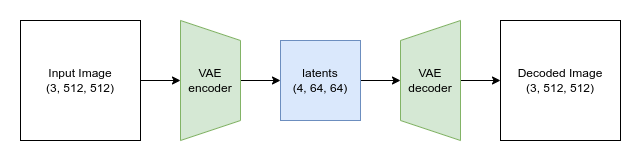

VAE (autoencoder variacional) es un tipo de modelo que puede codificar su entrada en una representación comprimida y luego decodificar esta representación 'latente' de vuelta a algo similar a la entrada original. Al generar imágenes con Stable Diffusion, primero **generamos los latentes** aplicando el proceso de difusión en el 'espacio latente' del VAE, y luego **los decodificamos al final** para ver la imagen resultante.

Aquí tienes un código que toma una imagen de entrada, la codifica a una representación latente y luego la decodifica nuevamente usando el VAE:

In [ ]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Como puedes ver, la imagen de 512x512 se comprime a una representación latente de 64x64 (con cuatro canales). Esta reducción de 8x en cada dimensión espacial es la razón por la que el ancho y alto especificados deben ser múltiplos de 8.

Trabajar con estos latentes de 4x64x64, ricos en información, es más eficiente que trabajar con imágenes de 512px, permitiendo modelos de difusión más rápidos y que requieren menos recursos para entrenar y usar. El proceso de decodificación del VAE no es perfecto, pero es lo suficientemente bueno como para que la pequeña pérdida de calidad valga la pena.

NB: El ejemplo de código anterior incluye el factor de escala 0.18215 necesario para coincidir con el procesamiento usado durante el entrenamiento de SD.

### El Tokenizador y Codificador de Texto


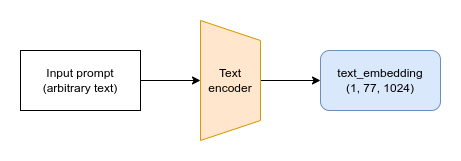

El objetivo del codificador de texto es convertir una cadena de entrada (el prompt) en una representación numérica que pueda ser utilizada por el UNet como condicionamiento. El texto primero se convierte en una serie de tokens usando el tokenizador del pipeline. El codificador de texto tiene un vocabulario de unos 50k tokens; cualquier palabra que no esté en este vocabulario se divide en sub-palabras más pequeñas. Los tokens se pasan por el modelo del codificador de texto, que es un transformer originalmente entrenado como codificador de texto para CLIP. Se espera que este transformer preentrenado haya aprendido representaciones ricas del texto útiles para la tarea de difusión.

Probemos este proceso codificando un prompt de ejemplo, primero tokenizando manualmente y pasándolo por el codificador de texto, y luego usando el método `encode_prompt` del pipeline para mostrar el proceso completo, incluyendo el padding/truncamento a la longitud máxima de 77 tokens:

In [ ]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

In [ ]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, True, '')
text_embeddings.shape

Estos embeddings de texto (los llamados 'hidden states' del último bloque transformer en el modelo codificador de texto) se pasarán al UNet como argumento adicional al método `forward`, que veremos en la siguiente sección.

### UNet

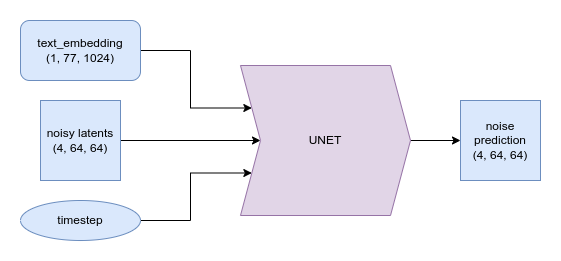

El UNet toma una entrada ruidosa y predice el ruido, igual que los UNet que hemos visto en unidades anteriores. A diferencia de esos ejemplos, la entrada no es una imagen sino una representación latente de una imagen. Y además del condicionamiento por timestep, este UNet también recibe los embeddings de texto del prompt como entrada adicional. Aquí está haciendo predicciones sobre datos de prueba:

In [ ]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

### Scheduler

El scheduler almacena la planificación de ruido y gestiona la actualización de la muestra ruidosa basada en las predicciones del modelo. El scheduler por defecto es un `PNDMScheduler`, pero puedes usar otros (como `LMSDiscreteScheduler`) siempre que se inicialicen con la misma configuración.

Podemos mostrar la planificación de ruido para ver el nivel de ruido (basado en $\bar{\alpha}$) a lo largo del tiempo

In [ ]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule');plt.legend()

Si quieres probar un scheduler diferente, puedes cambiarlo así:

In [ ]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

Puedes leer más sobre el uso de diferentes schedulers [aquí](https://huggingface.co/docs/diffusers/using-diffusers/schedulers).

### Un ciclo de muestreo DIY

Ahora que hemos visto todos estos componentes en acción, podemos juntarlos para replicar la funcionalidad del pipeline:

In [ ]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

En la mayoría de los casos será más fácil usar los pipelines existentes, pero tener este ciclo de muestreo personalizable puede ser útil para entender y modificar cómo funciona cada componente. Si quieres ver este código y todos los componentes explorados y modificados en profundidad, revisa el notebook 'Stable Diffusion Deep Dive' [notebook](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) y el [video](https://m.youtube.com/watch?v=0_BBRNYInx8) para una exploración más completa.

# Pipelines adicionales

¿Entonces qué más podemos hacer además de generar imágenes a partir de un prompt? ¡Bastante! En esta sección demostraremos algunos pipelines interesantes para que veas otras tareas en las que se puede usar Stable Diffusion. Varios de estos requieren descargar nuevos modelos, así que si tienes prisa puedes simplemente mirar los resultados existentes en vez de descargar y ejecutar todos los modelos tú mismo.

## Img2Img

En los ejemplos anteriores, generamos imágenes completamente desde cero comenzando con latentes aleatorios y aplicando el ciclo completo de muestreo de difusión. Pero no es necesario empezar desde cero. El pipeline Img2Img primero codifica una imagen existente en un conjunto de latentes, luego añade algo de ruido a los latentes y usa eso como punto de partida. La cantidad de ruido añadido y el número de pasos de denoising aplicados determinan la 'fuerza' del proceso img2img. Añadir solo una pequeña cantidad de ruido (baja fuerza) resultará en muy poco cambio, mientras que añadir la máxima cantidad de ruido y ejecutar el proceso completo de denoising dará una imagen que apenas se parece a la original, salvo algunas similitudes en la estructura general.

Para entender mejor el proceso img2img, implementémoslo manualmente. Este enfoque ayudará a aclarar cómo se codifican los latentes, se añade ruido y se aplica la difusión. Después de construir manualmente el pipeline, veremos cómo la librería diffusers proporciona un StableDiffusionImg2ImgPipeline listo para usar, para mayor simplicidad y eficiencia.

Así puedes implementar manualmente el pipeline img2img:

### Un ciclo Img2Img DIY

In [ ]:
import numpy as np

# Encode init_image
init_image_tensor = torch.from_numpy(np.array(init_image).transpose(2, 0, 1)).float() / 255.0 # 0~255 => 0~1
init_image_tensor = 2.0 * init_image_tensor - 1.0 # 0~1 => -1~1
init_image_tensor = init_image_tensor.unsqueeze(0).to(device) # add batch dim.

with torch.no_grad():
    init_image_latents = pipe.vae.encode(init_image_tensor).latent_dist.sample() * pipe.vae.config.scaling_factor

In [ ]:
guidance_scale = 7.5
num_inference_steps = 30
strength = 0.6
prompt = "An oil painting of a man on a bench"

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, '')

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Prepare latent variables
# We don't use all timesteps in the noise scheduler.
# Calculate a subset of timesteps based on `strength` to apply to the initial image.
init_timestep = min(int(num_inference_steps * strength), num_inference_steps)
t_start = max(num_inference_steps - init_timestep, 0)
timesteps = pipe.scheduler.timesteps[t_start:]
# The first timestep of the new timesteps will be the starting point for adding noise to the initial image.
latent_timestep = timesteps[:1]

# Add noise to init_image_latents at the noise level specified by latent_timestep.
noise = torch.randn((1, 4, 64, 64), device=device,
                    generator=torch.Generator(device=device).manual_seed(42))
latents = pipe.scheduler.add_noise(init_image_latents, noise, latent_timestep)

# Loop through the sampling timesteps
for i, t in enumerate(timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    result_image = pipe.vae.decode(latents_norm).sample

result_image = (result_image / 2 + 0.5).clamp(0, 1).squeeze()
result_image = (result_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
result_image = Image.fromarray(result_image)

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result')

Ahora que hemos implementado manualmente el proceso img2img, veamos cómo lograr lo mismo de manera más eficiente usando el StableDiffusionImg2ImgPipeline que provee la librería diffusers.

Este pipeline no requiere modelos especiales, así que mientras el ID del modelo sea el mismo que en el ejemplo de texto a imagen anterior, no será necesario descargar nuevos archivos.

### Pipeline Img2Img

In [ ]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

En la sección 'Configuración' cargamos una `init_image` de ejemplo para esta demo, pero puedes reemplazarla por tu propia imagen si lo prefieres. Así es como funciona el pipeline:

In [ ]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image, # The starting image
    strength=0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

**Ejercicio:** Experimenta con este pipeline. Prueba tus propias imágenes, o juega con diferentes valores de fuerza y prompts. Puedes usar muchos de los mismos argumentos que en el pipeline de texto a imagen, así que siéntete libre de probar diferentes tamaños, número de pasos, etc.

## Inpainting

¿Y si quisiéramos mantener parte de la imagen de entrada sin cambios pero generar algo nuevo en otras partes? Esto se llama 'inpainting'. Aunque se puede hacer con el mismo modelo de los ejemplos anteriores (usando `StableDiffusionInpaintPipelineLegacy`), se obtienen mejores resultados usando una versión personalizada de Stable Diffusion entrenada para tomar una imagen enmascarada y la máscara como condicionamiento adicional. La imagen de máscara debe tener el mismo tamaño que la imagen de entrada, con blanco en las áreas a reemplazar y negro en las áreas que deben permanecer sin cambios.

Para entender mejor el proceso de inpainting, implementemos manualmente la lógica detrás de StableDiffusionInpaintPipelineLegacy. Este enfoque aclarará cómo funciona el inpainting a bajo nivel y dará una idea de cómo Stable Diffusion procesa las entradas. Una vez completado esto, exploraremos el pipeline ajustado para comparación. Así puedes implementar manualmente el pipeline de inpainting y aplicarlo a la imagen y máscara de ejemplo cargadas en la sección 'Configuración':



![inpainting from_scratch](https://raw.githubusercontent.com/metamath1/diffusion-models-class/unit3/implement_img2img_inpaint/unit3/inpaint_from_scratch.png)

### Un ciclo de inpainting DIY

In [ ]:
# Resize mask image
mask_image_latent_size = mask_image.resize((64,64))
mask_image_latent_size = torch.tensor( (np.array(mask_image_latent_size)[...,0] > 5).astype(np.float32) )
plt.imshow(mask_image_latent_size.numpy(), cmap='gray')

mask_image_latent_size = mask_image_latent_size.to(device)
mask_image_latent_size.shape

Escribe nuevamente el ciclo de denoising.

In [ ]:
guidance_scale = 8
num_inference_steps = 30
prompt = "A small robot, high resolution, sitting on a park bench"
negative_prompt = "zoomed in, blurry, oversaturated, warped"
generator = torch.Generator(device=device).mansual_seed(42)

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

    # Perform inpainting to fill in the masked areas
    if i < len(pipe.scheduler.timesteps)-1:
        # Add noise to the original image's latent at the previous timestep t-1
        noise = torch.randn(init_image_latents.shape, generator=generator, device=device, dtype=torch.float32)
        background = pipe.scheduler.add_noise(init_image_latents, noise, torch.tensor([pipe.scheduler.timesteps[i+1]]))

        latents = latents*mask_image_latent_size # white in the areas
        background = background * (1-mask_image_latent_size) # black in the areas

        # Combine the generated and original image latents based on the mask
        latents += background

# Decode latents
latents_norm = latents / pipe.vae.config.scaling_factor

with torch.no_grad():
    inpainted_image = pipe.vae.decode(latents_norm).sample

inpainted_image = (inpainted_image / 2 + 0.5).clamp(0, 1).squeeze()
inpainted_image = (inpainted_image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
inpainted_image = Image.fromarray(inpainted_image)

inpainted_image

### Pipeline de Inpainting

Ahora que hemos implementado manualmente la lógica de inpainting, veamos cómo usar un pipeline ajustado específicamente para tareas de inpainting. Así es como cargamos dicho pipeline y lo aplicamos a la imagen y máscara de ejemplo cargadas en la sección 'Configuración':

![inpainting from_scratch](https://raw.githubusercontent.com/huggingface/diffusion-models-class/main/unit3/inpaint_w_border.jpg)
_Imagen de entrada, máscara y resultado generado (fuente: Hugging Face)_

In [ ]:
# Load the inpainting pipeline (requires a suitable inpainting model)
# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")

# "runwayml/stable-diffusion-inpainting" is no longer available.
# Therefore, we are using the "stabilityai/stable-diffusion-2-inpainting" model instead.
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting")
pipe = pipe.to(device)

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result')

Esto puede ser especialmente potente cuando se combina con otro modelo para generar máscaras automáticamente. Por ejemplo, [esta demo](https://huggingface.co/spaces/nielsr/text-based-inpainting) usa un modelo llamado CLIPSeg para enmascarar un objeto a reemplazar basado en una descripción de texto.

### Nota: Gestionando tu caché de modelos

Explorar diferentes pipelines y variantes de modelos puede llenar tu disco. Puedes ver qué modelos tienes descargados con:

In [ ]:
!ls ~/.cache/huggingface/hub/ # List the contents of the cache directory

Consulta [la documentación sobre caché](https://huggingface.co/docs/huggingface_hub/main/en/how-to-cache) para ver cómo gestionar tu caché de manera efectiva.

## Profundidad2Imagen


![depth to image examples](https://camo.githubusercontent.com/50c14634d9ff835abd36693cccbdb12fc153e56226414186012641ab75b70b6f/68747470733a2f2f68756767696e67666163652e636f2f73746162696c69747961692f737461626c652d646966667573696f6e2d322d64657074682f7265736f6c76652f6d61696e2f646570746832696d6167652e706e67)
_Imagen de entrada, imagen de profundidad y ejemplos generados (fuente: StabilityAI)_

Img2Img es genial, pero a veces queremos crear una nueva imagen con la composición de la original pero colores o texturas completamente diferentes. Puede ser difícil encontrar una fuerza de Img2Img que conserve la disposición deseada sin mantener también los colores de entrada.

¡Hora de otro modelo ajustado! Este toma información de profundidad como condicionamiento adicional al generar. El pipeline usa un modelo de estimación de profundidad para crear un mapa de profundidad, que luego se pasa al UNet ajustado al generar imágenes para (con suerte) preservar la profundidad y estructura de la imagen inicial mientras se rellena con contenido completamente nuevo.

In [ ]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result')

Observa cómo la salida se compara con el ejemplo de img2img: aquí hay mucha más variación de color, pero la estructura general sigue siendo fiel a la original. Esto no es ideal en este caso ya que el hombre ha recibido una anatomía muy extraña para coincidir con la forma del perro, pero en algunos casos esto es extremadamente útil. Para un ejemplo del 'caso de uso estrella' de este enfoque, revisa [este tweet](https://twitter.com/CarsonKatri/status/1600248599254007810?s=20&t=BlzSK26sfqi2336SN0gKpQ) mostrando el modelo de profundidad siendo usado para texturizar una escena 3D.

## Ejercicio 

Prueba a seleccionar el modelo que más te guste de la lista de modelos de generación de imágenes y emplea gradio para crear una interfaz de usuario que permita generar imágenes.

In [ ]:
# Tu codigo aqui
